In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping




In [2]:
!pip install keras-tcn
from tcn import TCN

In [3]:
url = 'https://raw.githubusercontent.com/mkumakech/Covid-19_Pandemic/refs/heads/master/kano%20(1).csv'
df = pd.read_csv(url)

In [4]:
print(df.head())

  State  Confirmed  Discharged  Death        Date
0  Kano         92           0      0  01/05/2020
1  Kano          2           7      3  02/05/2020
2  Kano         29           0      0  03/05/2020
3  Kano         23           0      2  04/05/2020
4  Kano         32           3      3  05/05/2020


In [5]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Sort by date
df = df.sort_values('Date')

# Select relevant columns
data = df[['Death', 'Discharged', 'Confirmed']].fillna(0)

# Normalize data for each target separately
scalers = {}
scaled_data = pd.DataFrame()

for col in data.columns:
    scaler = MinMaxScaler()
    scaled_col = scaler.fit_transform(data[col].values.reshape(-1,1))
    scaled_data[col] = scaled_col.flatten()
    scalers[col] = scaler

print(scaled_data.head())


   Death  Discharged  Confirmed
0  0.000    0.000000   0.786325
1  0.375    0.067961   0.017094
2  0.000    0.000000   0.247863
3  0.250    0.000000   0.196581
4  0.375    0.029126   0.273504


In [6]:
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7

# Create sequences for each target
X_Death, y_Death = create_sequences(scaled_data['Death'].values, seq_length)
X_Discharged, y_Discharged = create_sequences(scaled_data['Discharged'].values, seq_length)
X_Confirmed, y_Confirmed = create_sequences(scaled_data['Confirmed'].values, seq_length)

# Reshape X for models (samples, time_steps, features=1)
X_Death = X_Death.reshape((X_Death.shape[0], X_Death.shape[1], 1))
X_Discharged = X_Discharged.reshape((X_Discharged.shape[0], X_Discharged.shape[1], 1))
X_Confirmed = X_Confirmed.reshape((X_Confirmed.shape[0], X_Confirmed.shape[1], 1))


In [7]:
split_ratio = 0.8
def train_test_split(X, y):
    split = int(len(X)*split_ratio)
    return X[:split], X[split:], y[:split], y[split:]

X_Death_train, X_Death_test, y_Death_train, y_Death_test = train_test_split(X_Death, y_Death)
X_Discharged_train, X_Discharged_test, y_Discharged_train, y_Discharged_test = train_test_split(X_Discharged, y_Discharged)
X_Confirmed_train, X_Confirmed_test, y_Confirmed_train, y_Confirmed_test = train_test_split(X_Confirmed, y_Confirmed)


In [8]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [9]:
def build_gru_model(input_shape):
    model = Sequential([
        GRU(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [10]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [11]:
def build_tcn_model(input_shape):
    model = Sequential([
        TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4], input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [12]:
def train_and_evaluate(X_train, y_train, X_test, y_test, build_model_fn, model_name, target_name):
    model = build_model_fn(X_train.shape[1:])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    # Predictions
    y_pred = model.predict(X_test).flatten()

    # Inverse scale
    y_test_inv = scalers[target_name].inverse_transform(y_test.reshape(-1,1)).flatten()
    y_pred_inv = scalers[target_name].inverse_transform(y_pred.reshape(-1,1)).flatten()

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f'{model_name} - {target_name} - MSE: {mse:.3f}, MAE: {mae:.3f}')

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title(f'{model_name} Prediction for {target_name}')
    plt.legend()
    plt.show()

    return mse, mae



--- Predictions for DEATH ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
LSTM - Death - MSE: 0.226, MAE: 0.346


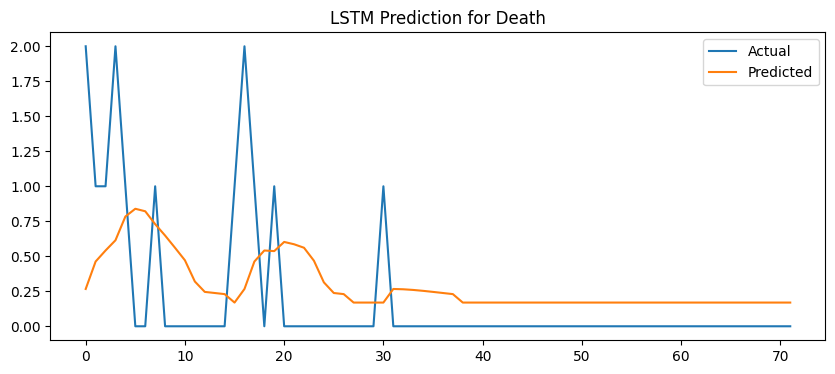

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
GRU - Death - MSE: 0.213, MAE: 0.378


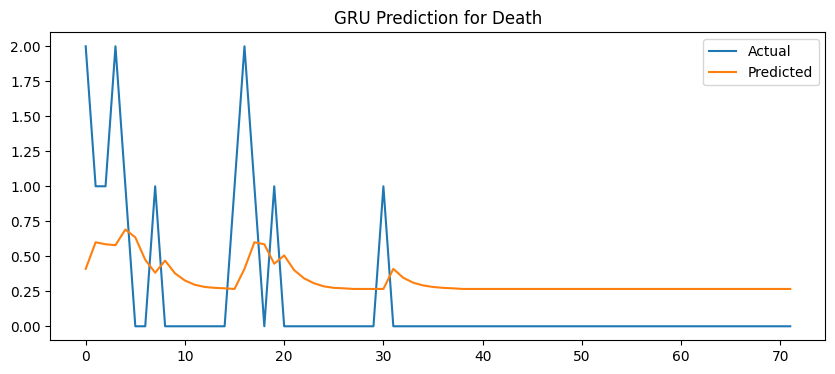

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
CNN - Death - MSE: 0.252, MAE: 0.330


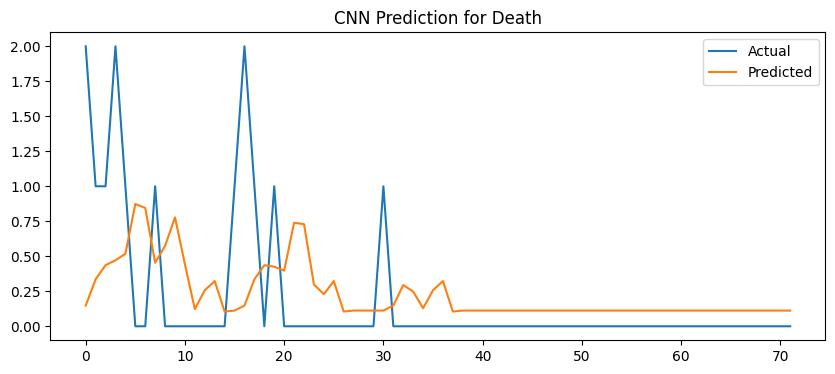

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
TCN - Death - MSE: 0.400, MAE: 0.382


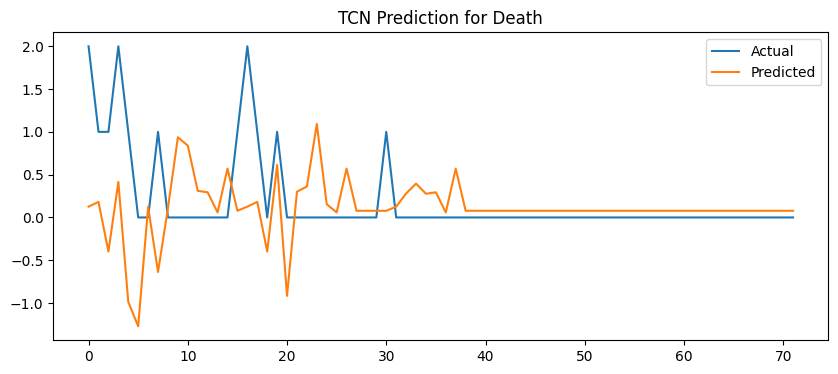


--- Predictions for DISCHARGED ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
LSTM - Discharged - MSE: 82.879, MAE: 6.305


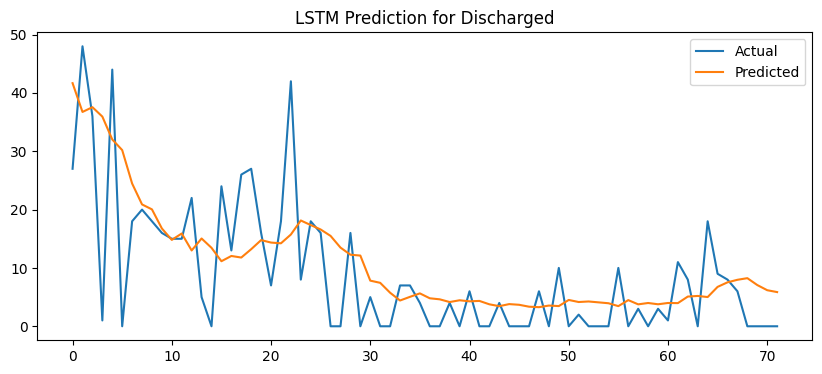

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
GRU - Discharged - MSE: 83.639, MAE: 6.570


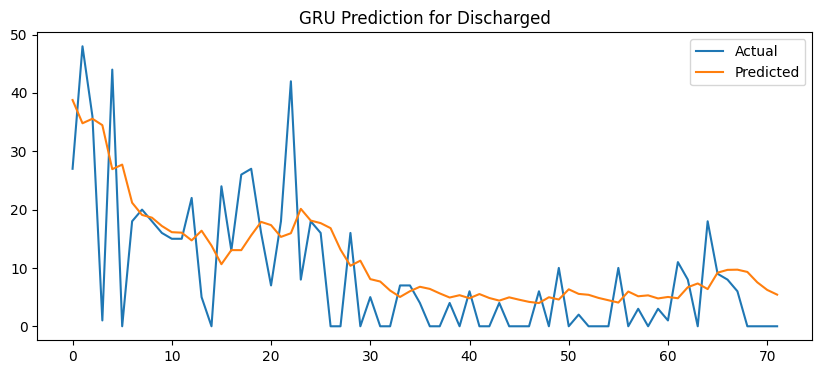

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
CNN - Discharged - MSE: 81.298, MAE: 6.575


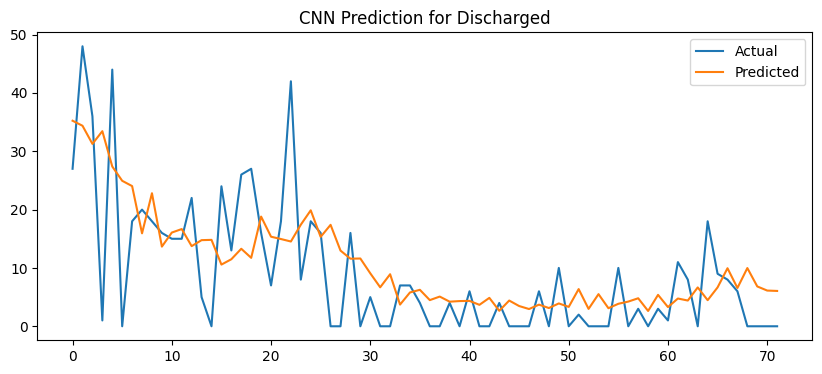

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
TCN - Discharged - MSE: 113.216, MAE: 6.829


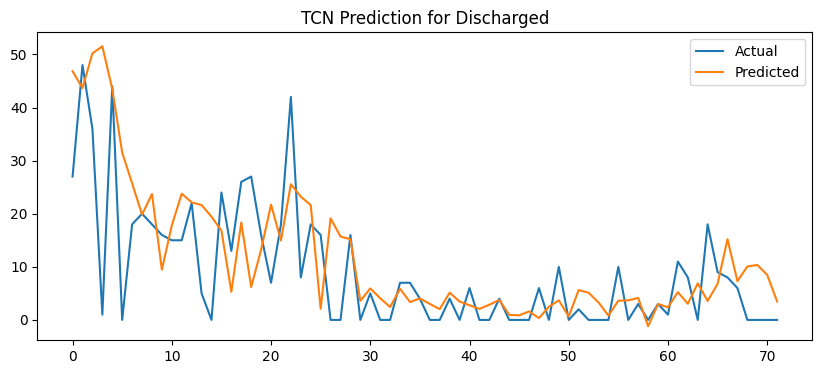


--- Predictions for CONFIRMED ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
LSTM - Confirmed - MSE: 63.019, MAE: 5.588


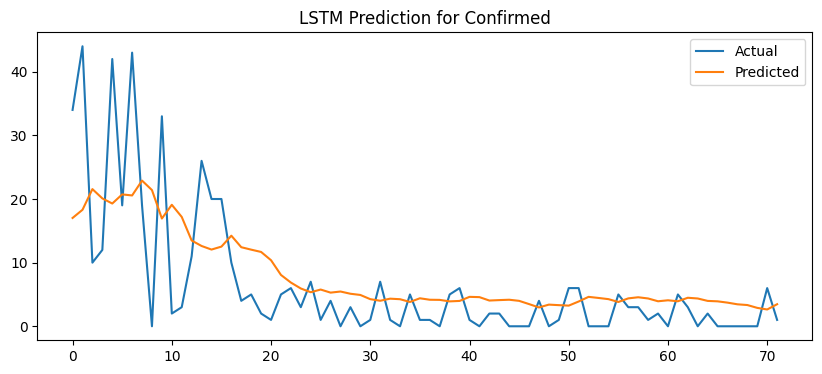

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
GRU - Confirmed - MSE: 62.526, MAE: 5.403


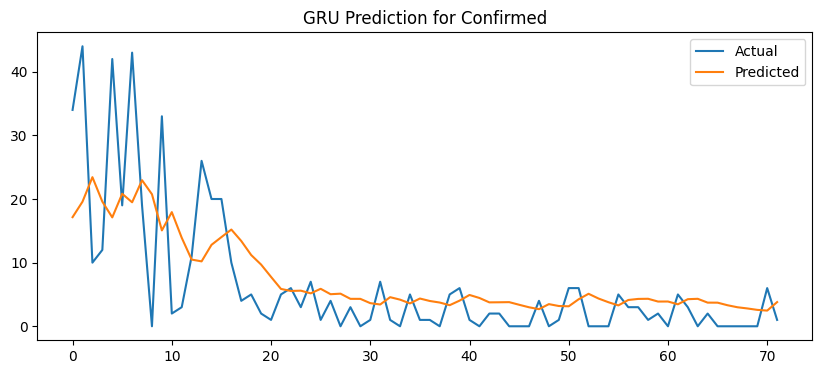

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
CNN - Confirmed - MSE: 62.338, MAE: 5.619


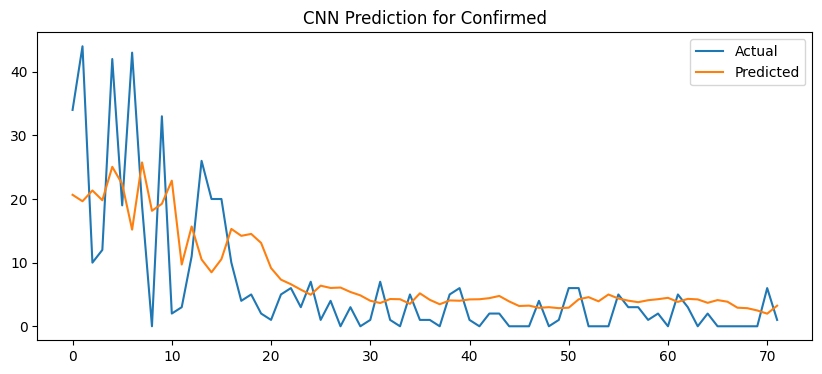

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
TCN - Confirmed - MSE: 73.665, MAE: 6.169


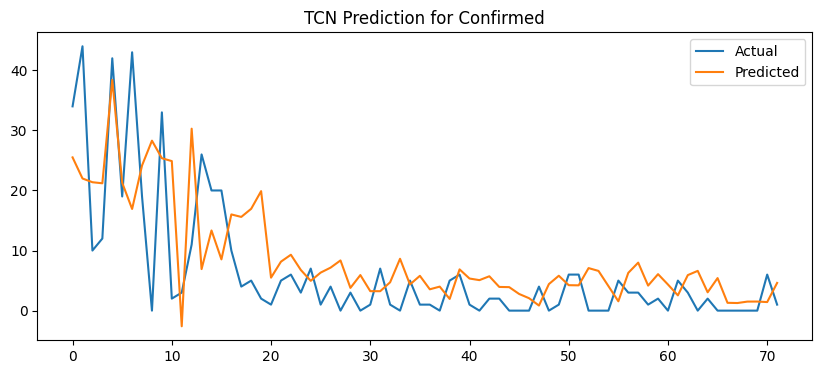

In [13]:
models = {
    'LSTM': build_lstm_model,
    'GRU': build_gru_model,
    'CNN': build_cnn_model,
    'TCN': build_tcn_model
}

targets = {
    'Death': (X_Death_train, y_Death_train, X_Death_test, y_Death_test),
    'Discharged': (X_Discharged_train, y_Discharged_train, X_Discharged_test, y_Discharged_test),
    'Confirmed': (X_Confirmed_train, y_Confirmed_train, X_Confirmed_test, y_Confirmed_test)
}

results = {}

for target_name, (X_tr, y_tr, X_te, y_te) in targets.items():
    print(f'\n--- Predictions for {target_name.upper()} ---')
    results[target_name] = {}
    for model_name, build_fn in models.items():
        mse, mae = train_and_evaluate(X_tr, y_tr, X_te, y_te, build_fn, model_name, target_name)
        results[target_name][model_name] = {'MSE': mse, 'MAE': mae}


In [14]:
for target_name in results:
    print(f'\nPerformance for {target_name.upper()}:')
    sorted_models = sorted(results[target_name].items(), key=lambda x: x[1]['MSE'])
    for model_name, metrics in sorted_models:
        print(f"{model_name}: MSE={metrics['MSE']:.3f}, MAE={metrics['MAE']:.3f}")
    best_model = sorted_models[0][0]
    print(f"Best model for {target_name}: {best_model}")



Performance for DEATH:
GRU: MSE=0.213, MAE=0.378
LSTM: MSE=0.226, MAE=0.346
CNN: MSE=0.252, MAE=0.330
TCN: MSE=0.400, MAE=0.382
Best model for Death: GRU

Performance for DISCHARGED:
CNN: MSE=81.298, MAE=6.575
LSTM: MSE=82.879, MAE=6.305
GRU: MSE=83.639, MAE=6.570
TCN: MSE=113.216, MAE=6.829
Best model for Discharged: CNN

Performance for CONFIRMED:
CNN: MSE=62.338, MAE=5.619
GRU: MSE=62.526, MAE=5.403
LSTM: MSE=63.019, MAE=5.588
TCN: MSE=73.665, MAE=6.169
Best model for Confirmed: CNN
